# Prediction Of Preoperative Risk

In [1]:
#importing all necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

# machine learning
from sklearn.model_selection import (GridSearchCV,StratifiedKFold,train_test_split)
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import (log_loss,confusion_matrix,classification_report,ConfusionMatrixDisplay,roc_curve,accuracy_score)
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.model_selection import KFold,cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression
import plotly.offline as pyo
from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore")

#  Postoperative mortality risk based on preoperative data
Accurate knowledge of individual patient risk is essential to raise awareness for early recognition of postoperative complications and adequate planning of intraoperative management and postoperative care. Furthermore, from an ethical and legal point of view, the patient has the right to know his or her risk of the planned procedure to enable shared decision making with physician and patient.
Objective is to make the model comprehensible for the physician.


### Loading the dataset

In [2]:
#reading the data
df=pd.read_csv("clinical_data.csv")
df.head()

#Using list(df) to get the list of all Column Names
column_headers = list(df)
print(column_headers)

['case_id', 'subjectid', 'casestart', 'caseend', 'anestart', 'aneend', 'opstart', 'opend', 'adm', 'dis', 'icu_days', 'death_inhosp', 'age', 'sex', 'height', 'weight', 'bmi', 'asa', 'emop', 'department', 'optype', 'dx', 'opname', 'approach', 'position', 'ane_type', 'preop_htn', 'preop_dm', 'preop_ecg', 'preop_pft', 'preop_hb', 'preop_plt', 'preop_pt', 'preop_aptt', 'preop_na', 'preop_k', 'preop_gluc', 'preop_alb', 'preop_ast', 'preop_alt', 'preop_bun', 'preop_cr', 'preop_ph', 'preop_hco3', 'preop_be', 'preop_pao2', 'preop_paco2', 'preop_sao2', 'cormack', 'airway', 'tubesize', 'dltubesize', 'lmasize', 'iv1', 'iv2', 'aline1', 'aline2', 'cline1', 'cline2', 'intraop_ebl', 'intraop_uo', 'intraop_rbc', 'intraop_ffp', 'intraop_crystalloid', 'intraop_colloid', 'intraop_ppf', 'intraop_mdz', 'intraop_ftn', 'intraop_rocu', 'intraop_vecu', 'intraop_eph', 'intraop_phe', 'intraop_epi', 'intraop_ca']


In [3]:
# Rename a single column permanently
df.rename(columns={'death_inhosp': 'outcome'}, inplace=True)

In [47]:
#total number of records
print(df.shape) #6388

(6388, 74)


In [70]:
#As our aim is to assess risk of postoperative mortality based on preoperative data
#selecting only relevant columns
preop_df=df[['emop','dx','outcome','adm','icu_days', 'age', 'bmi', 'asa','sex','department','optype','ane_type'
       ,'preop_htn', 'preop_dm', 'preop_ecg', 'preop_pft', 'preop_hb',
       'preop_plt', 'preop_pt', 'preop_aptt', 'preop_na', 'preop_k',
       'preop_gluc', 'preop_alb', 'preop_ast', 'preop_alt', 'preop_bun',
       'preop_cr']]

### Excluding underage  and emergency patients

In [71]:

print(preop_df.info())

pd.set_option('display.max_columns', None)# as age column is not displaying
print(preop_df['age'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6388 entries, 0 to 6387
Data columns (total 28 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   emop        6388 non-null   int64  
 1   dx          6388 non-null   object 
 2   outcome     6388 non-null   int64  
 3   adm         6388 non-null   int64  
 4   icu_days    6388 non-null   int64  
 5   age         6388 non-null   object 
 6   bmi         6388 non-null   float64
 7   asa         6255 non-null   float64
 8   sex         6388 non-null   object 
 9   department  6388 non-null   object 
 10  optype      6388 non-null   object 
 11  ane_type    6388 non-null   object 
 12  preop_htn   6388 non-null   int64  
 13  preop_dm    6388 non-null   int64  
 14  preop_ecg   6388 non-null   object 
 15  preop_pft   6388 non-null   object 
 16  preop_hb    6047 non-null   float64
 17  preop_plt   6047 non-null   float64
 18  preop_pt    5998 non-null   float64
 19  preop_aptt  5986 non-null  

In [72]:
#as age datatype: object ..we have to convert it into integer for removing records of underage

# Identify decimal values in the 'age' column
decimal_values = preop_df[preop_df['age'].str.contains('\.')]

# Check if decimal_values is empty
if decimal_values.empty:
    print("No decimal values found in the 'age' column.")
else:
    print("Found decimal values in the 'age' column:")
    print(decimal_values)
    
preop_df = preop_df[~preop_df['age'].str.contains('\.')]
# Remove rows with '>89' values in the 'age' column
preop_df = preop_df[~preop_df['age'].str.contains('>')]

print(preop_df['age'])


preop_df['age'] = preop_df['age'].astype('int')
#checking underage

# Count the number of records of underage patients
count_underage = preop_df[preop_df['age'] <18].shape[0]
print("Number of records of underage ", count_underage)

count_valid = preop_df[preop_df['age'] >=18].shape[0]
print("Number of records of patients aged 18 and above ", count_valid)

Found decimal values in the 'age' column:
      emop                            dx  outcome      adm  icu_days  age  \
263      1         Primary hyperoxaluria        0 -1534620        38  0.7   
279      0              Biliary atresia         0  -294240        15  0.6   
365      0                 Hyperoxaluria        0 -4091460        38  0.8   
2319     1                Hepatoblastoma        0  -844560         6  0.3   
3229     1         Primary hyperoxaluria        1 -2212920        38  0.7   
3485     1         Primary hyperoxaluria        1 -3281580        38  0.7   
4646     1       Liver transplant status        1 -1450080        17  0.4   
4877     1              Biliary atresia         0  -874920        15  0.7   
5502     1                 Hyperoxaluria        1 -2056500        38  0.7   
6336     1  Hepatic failure without coma        1 -1286520        17  0.4   

       bmi  asa sex       department           optype ane_type  preop_htn  \
263   21.7  4.0   F  General surg

In [73]:
#removing underage
preop_df=preop_df.loc[(preop_df['age']>=18)]
print(preop_df.shape)

(6323, 28)


In [74]:
#removing  emergency patients
preop_df = preop_df.loc[(preop_df['emop']==0)]
print(preop_df.shape)

(5567, 28)


In [75]:
# Count the number of records of emergency patients
count_emergency = preop_df[preop_df['emop'] == 1].shape[0]
print("Number of records ", count_emergency)

# Count the number of records of underage patients
count_underage = preop_df[preop_df['age'] <18].shape[0]
print("Number of records ", count_underage)

Number of records  0
Number of records  0


### Excluding icu patients and ASA with greater than 5

In [76]:
#checking how many patients are icu patients
count_icu = preop_df[preop_df['icu_days'] > 0].shape[0]
print("Number of records of icu patients", count_icu)

# Count the number of records of patients with ASA >5
count_ASA = preop_df[preop_df['asa'] >5].shape[0]
print("Number of records of asa >5", count_ASA)

Number of records of icu patients 927
Number of records of asa >5 11


In [77]:
final_preop_cases = preop_df.loc[(preop_df['icu_days']==0)&  (preop_df['asa']<5)]
print(final_preop_cases.shape)


(4565, 28)


In [78]:
#after removing,
#checking how many patients are icu patients
count_icu = final_preop_cases[final_preop_cases['icu_days'] > 0].shape[0]
print("Number of records of icu patients", count_icu)

# Count the number of records of patients with ASA >5
count_ASA = final_preop_cases[final_preop_cases['asa'] >5].shape[0]
print("Number of records of asa >5", count_ASA)

Number of records of icu patients 0
Number of records of asa >5 0


In [79]:
final_preop_cases.describe()

,emop,outcome,adm,icu_days,age,bmi,asa,preop_htn,preop_dm,preop_hb,preop_plt,preop_pt,preop_aptt,preop_na,preop_k,preop_gluc,preop_alb,preop_ast,preop_alt,preop_bun,preop_cr
count,4565.0,4565.000000,4.565000e+03,4565.0,4565.000000,4565.000000,4565.000000,4565.000000,4565.000000,4431.000000,4429.000000,4392.000000,4382.000000,4232.000000,4233.000000,4405.000000,4419.000000,4423.000000,4422.000000,4419.000000,4420.000000
mean,0.0,0.003943,-2.305566e+05,0.0,56.658708,23.534414,1.727930,0.292004,0.092881,13.088919,246.273651,102.247040,32.481378,140.344282,4.202599,111.986379,4.156461,23.772779,23.364767,14.978276,0.967373
std,0.0,0.062677,2.914652e+05,0.0,14.060439,3.515148,0.578631,0.454734,0.290297,1.834903,78.843146,12.630309,3.928839,2.454761,0.376386,36.207688,0.429145,17.734758,25.371266,8.482345,1.229971
min,0.0,0.000000,-4.969620e+06,0.0,18.000000,12.900000,1.000000,0.000000,0.000000,6.100000,5.000000,26.000000,19.200000,119.000000,2.900000,44.000000,0.800000,2.000000,1.000000,3.000000,0.280000
25%,0.0,0.000000,-2.212200e+05,0.0,47.000000,21.100000,1.000000,0.000000,0.000000,12.000000,197.000000,95.000000,30.100000,139.000000,4.000000,94.000000,3.900000,17.000000,13.000000,11.000000,0.660000
50%,0.0,0.000000,-2.008800e+05,0.0,58.000000,23.300000,2.000000,0.000000,0.000000,13.200000,238.000000,103.000000,32.100000,141.000000,4.200000,102.000000,4.200000,20.000000,18.000000,14.000000,0.770000
75%,0.0,0.000000,-1.287000e+05,0.0,67.000000,25.600000,2.000000,1.000000,0.000000,14.300000,285.000000,110.000000,34.300000,142.000000,4.400000,117.000000,4.400000,25.000000,26.000000,17.000000,0.930000
max,0.0,1.000000,-3.552000e+04,0.0,89.000000,43.200000,4.000000,1.000000,1.000000,19.300000,1156.000000,159.000000,101.300000,148.000000,6.300000,525.000000,5.300000,528.000000,767.000000,127.000000,20.730000


In [80]:
#dropping unnecessary columns
final_preop_cases=final_preop_cases.drop(['emop', 'icu_days','dx','adm'], axis=1)

In [81]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


## Checking missing data 

<AxesSubplot:>

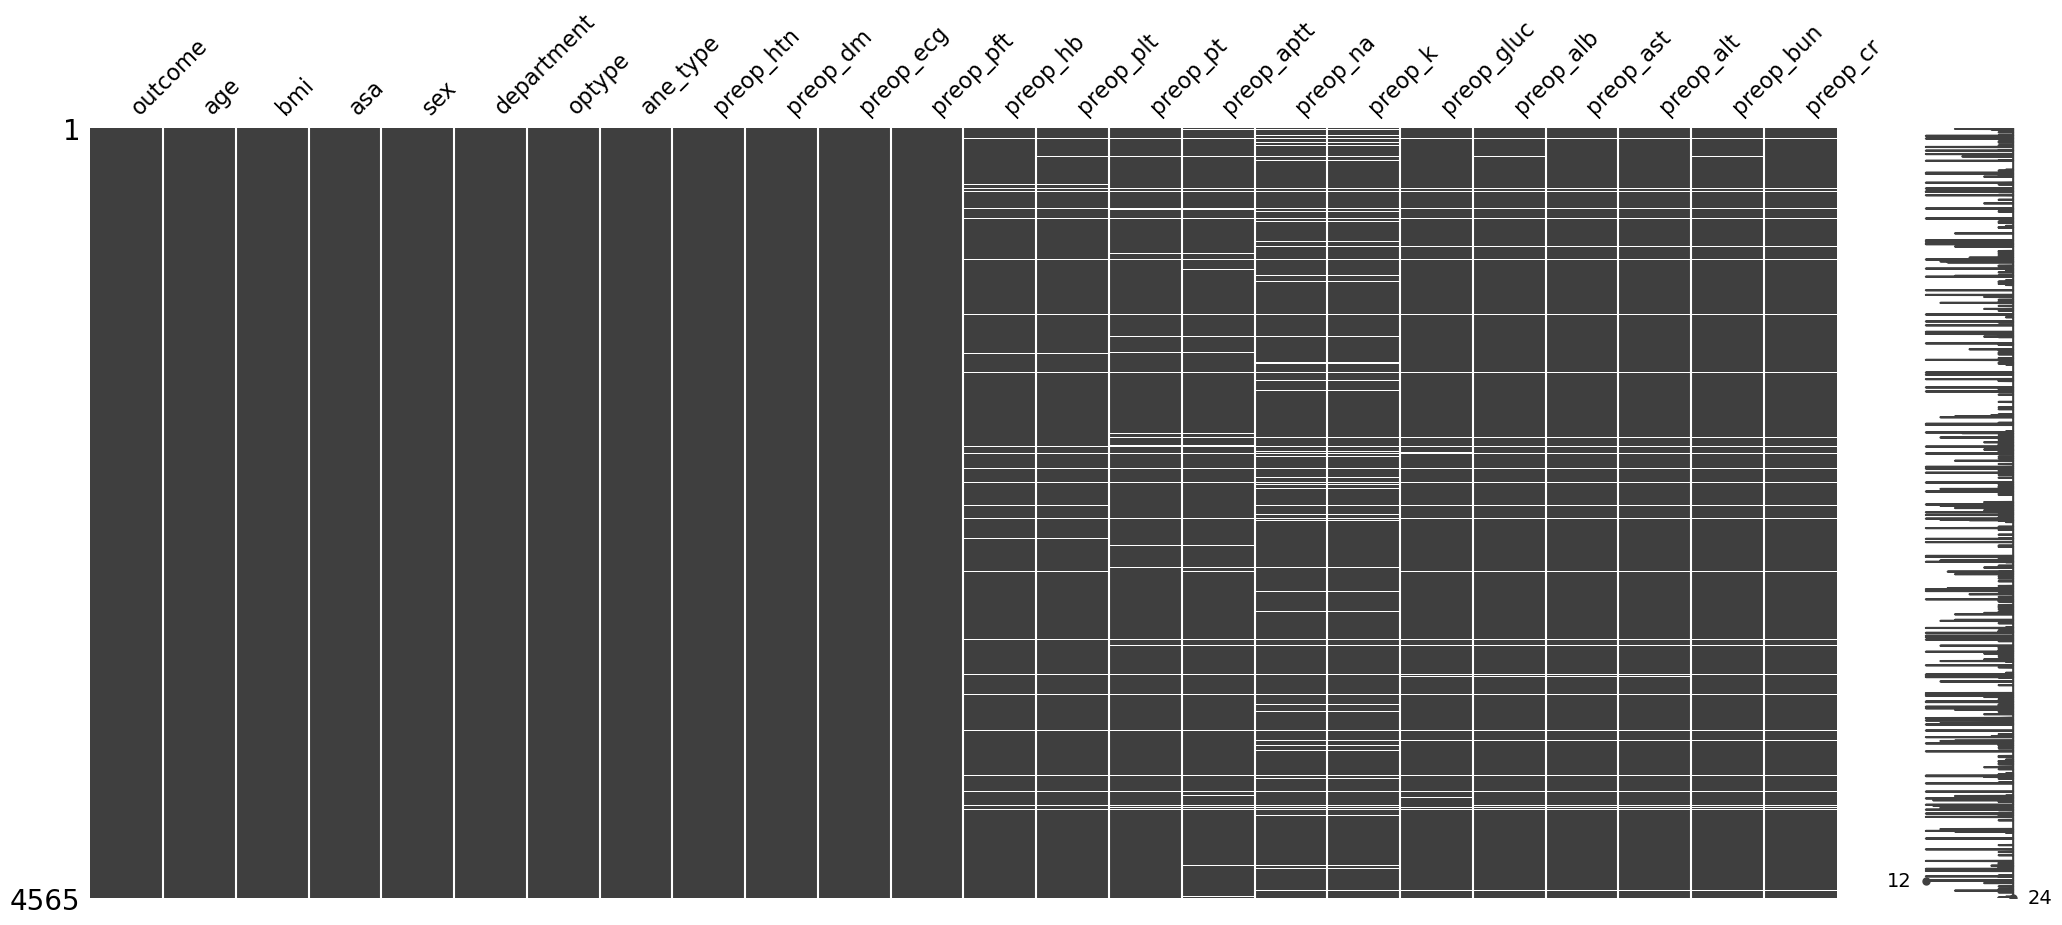

In [82]:

#it has been noticed that data has been missing from any column in the data.

import missingno

missingno.matrix(final_preop_cases)

In [83]:
print(final_preop_cases.shape)
final_preop_cases.isnull().sum()

(4565, 24)


outcome         0
age             0
bmi             0
asa             0
sex             0
department      0
optype          0
ane_type        0
preop_htn       0
preop_dm        0
preop_ecg       0
preop_pft       0
preop_hb      134
preop_plt     136
preop_pt      173
preop_aptt    183
preop_na      333
preop_k       332
preop_gluc    160
preop_alb     146
preop_ast     142
preop_alt     143
preop_bun     146
preop_cr      145
dtype: int64

In [165]:
check_outliers=['preop_hb',
       'preop_plt', 'preop_pt', 'preop_aptt', 'preop_na', 'preop_k',
       'preop_gluc', 'preop_alb', 'preop_ast', 'preop_alt', 'preop_bun','preop_cr']
outliers=[]
def detect_outliers(data):
    threshold=3
    mean=np.mean(data)
    std=np.std(data)

    for i in data:
        z_score=(i-mean)/std
        if np.abs(z_score)>threshold:
            outliers.append(i)
    return outliers

In [166]:
for column_name in check_outliers:
    column_data = final_preop_cases[column_name]
    column_outliers = detect_outliers(column_data)
    outlier_count = len(column_outliers)
    print(f"Number of outliers in column '{column_name}': {outlier_count}")

Number of outliers in column 'preop_hb': 17
Number of outliers in column 'preop_plt': 71
Number of outliers in column 'preop_pt': 128
Number of outliers in column 'preop_aptt': 169
Number of outliers in column 'preop_na': 218
Number of outliers in column 'preop_k': 269
Number of outliers in column 'preop_gluc': 368
Number of outliers in column 'preop_alb': 429
Number of outliers in column 'preop_ast': 483
Number of outliers in column 'preop_alt': 519
Number of outliers in column 'preop_bun': 591
Number of outliers in column 'preop_cr': 677


In [167]:
columns_to_impute_mean= ['preop_hb','preop_plt', 'preop_pt','preop_aptt','preop_na','preop_k','preop_gluc']
final_preop_cases[columns_to_impute_mean] = final_preop_cases[columns_to_impute_mean].fillna(final_preop_cases[columns_to_impute_mean].mean())
final_preop_cases[columns_to_impute_mean]=final_preop_cases[columns_to_impute_mean].round(2)

In [168]:
columns_to_impute_median = [ 
       'preop_ast','preop_bun','preop_alb','preop_cr']

final_preop_cases[columns_to_impute_median] = final_preop_cases[columns_to_impute_median].fillna(final_preop_cases[columns_to_impute_median].median().round(2))
final_preop_cases[columns_to_impute_median]=final_preop_cases[columns_to_impute_median].round(2)



In [86]:
final_preop_cases.isnull().sum()

outcome       0
age           0
bmi           0
asa           0
sex           0
department    0
optype        0
ane_type      0
preop_htn     0
preop_dm      0
preop_ecg     0
preop_pft     0
preop_hb      0
preop_plt     0
preop_pt      0
preop_aptt    0
preop_na      0
preop_k       0
preop_gluc    0
preop_alb     0
preop_ast     0
preop_alt     0
preop_bun     0
preop_cr      0
dtype: int64

<AxesSubplot:>

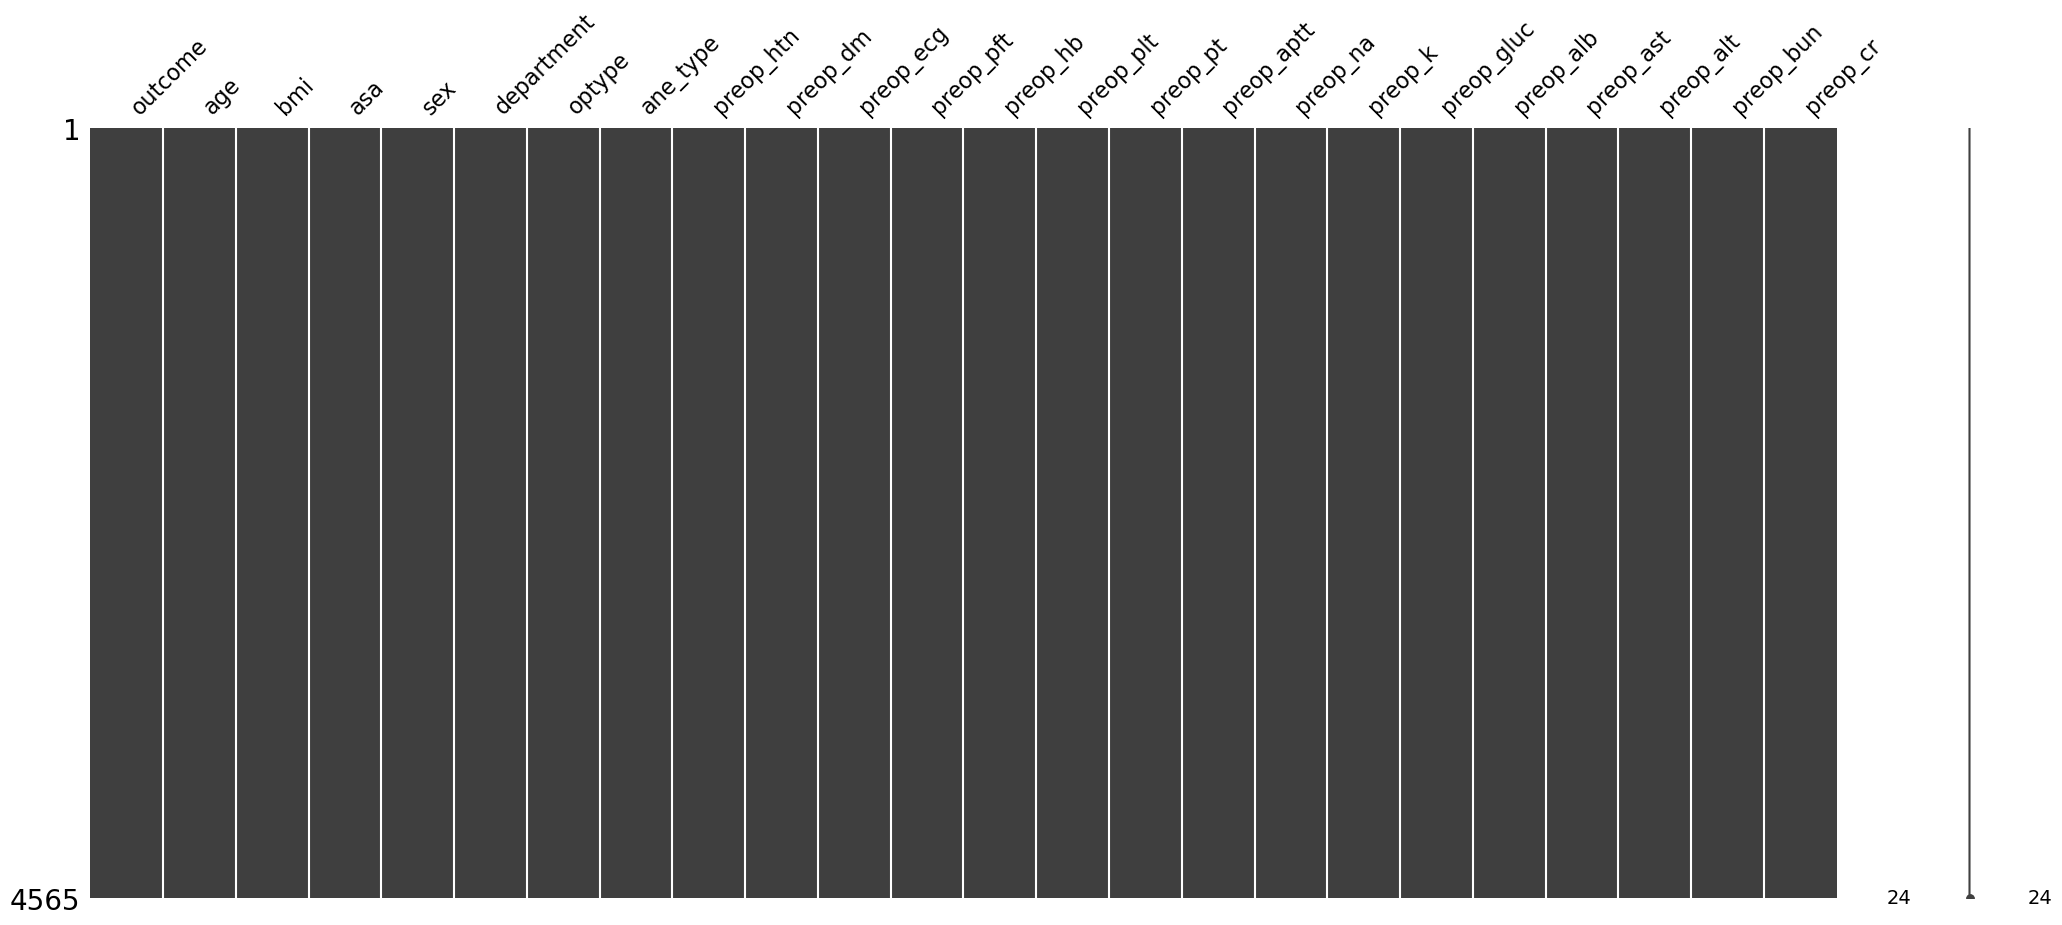

In [87]:
missingno.matrix(final_preop_cases)

# Bivariate Analysis

Scatter plots of features(x axis) with target variable(y axis) were plotted out to understand the relationship between the features and target variable.

From the plots, no linear relationship could be found out between the target variable and features

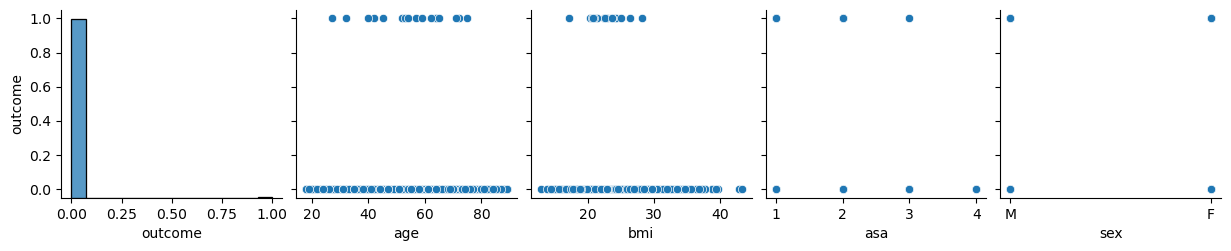

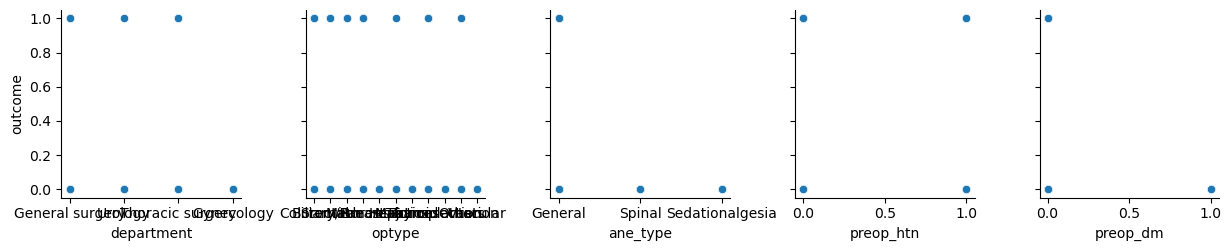

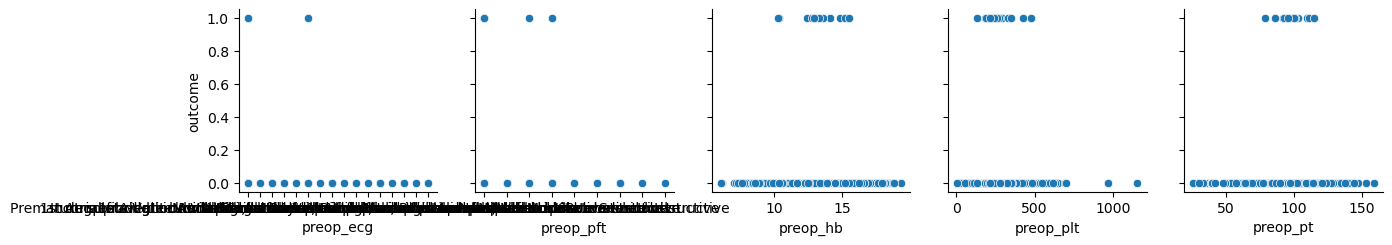

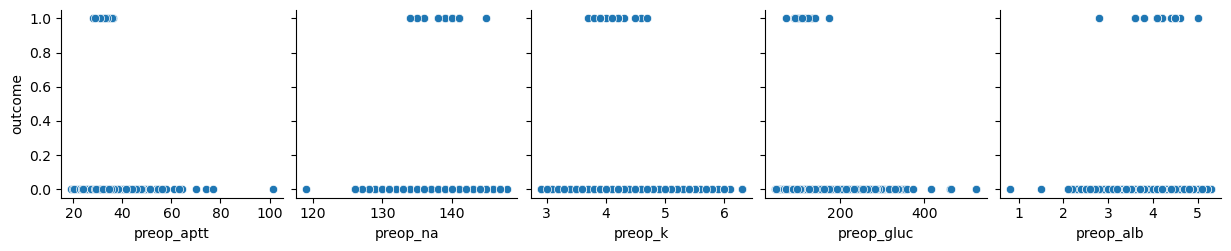

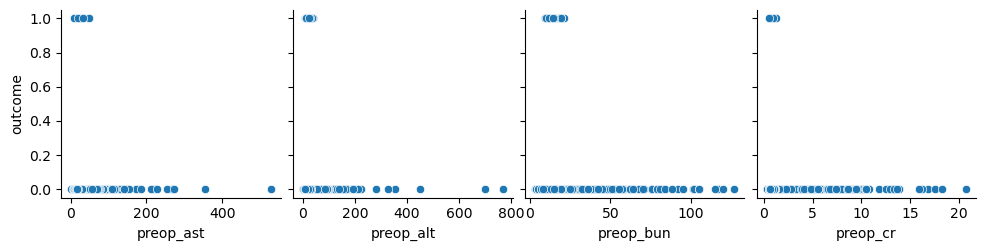

In [88]:
for i in range(0, len(final_preop_cases.columns), 5):
    sns.pairplot(data=final_preop_cases,
                x_vars=final_preop_cases.columns[i:i+5],
                y_vars=['outcome'])

### Correlation Matrix
As no linear relationship was found between the target varible and features, Pearsons's correlation was calculated for the data and following insights were found out -
1. Positive Correlations:
   - Preoperative Platelet Count (preop_plt) and Preoperative Hemoglobin (preop_hb) show a moderate positive correlation.
   - Preoperative Creatinine (preop_cr) and Blood Urea Nitrogen (preop_bun) exhibit a strong positive correlation.
2. Weak Correlations:
   - Most of the other selected features show weak correlations with each other, indicating a lack of strong linear relationships.

<Figure size 1000x800 with 0 Axes>

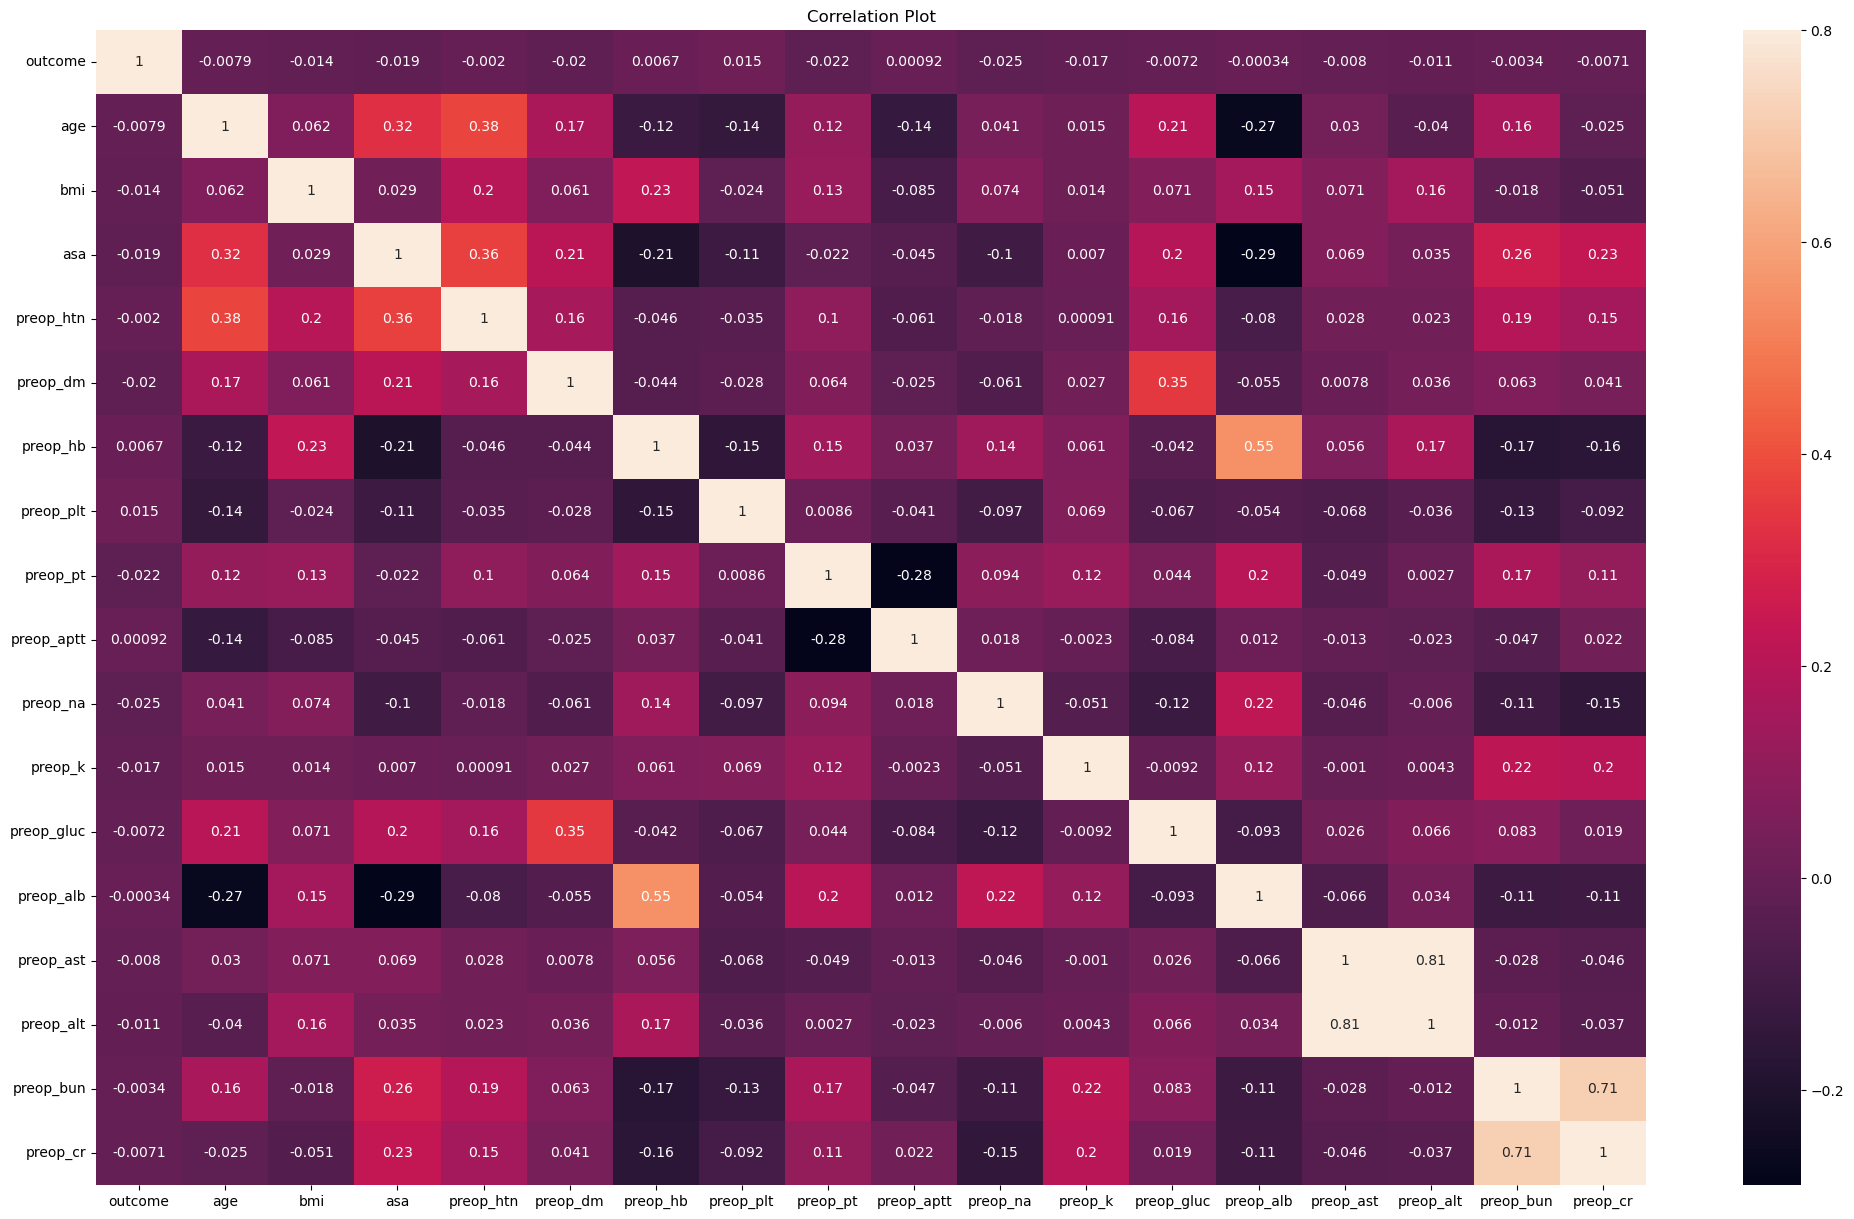

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

final_preop_cases_numeric = final_preop_cases.select_dtypes(include=['number'])
correlation_matrix = final_preop_cases_numeric.corr()


# Assuming 'df' is your DataFrame containing the variables for which you want to create the correlation plot
# You can replace 'df' with your actual DataFrame and select the specific columns you want to include in the correlation plot



# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
f, ax = plt.subplots(figsize=(25, 15))
sns.heatmap(correlation_matrix, vmax=.8, annot=True)
plt.title('Correlation Plot')
plt.show()

(array([3752.,    0.,    0.,  112.,    0.,    0.,  515.,    0.,    0.,
         186.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

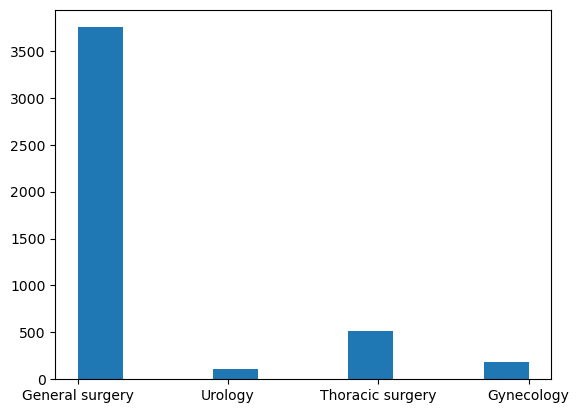

In [92]:
plt.hist(final_preop_cases['department'])

(array([2159.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2406.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

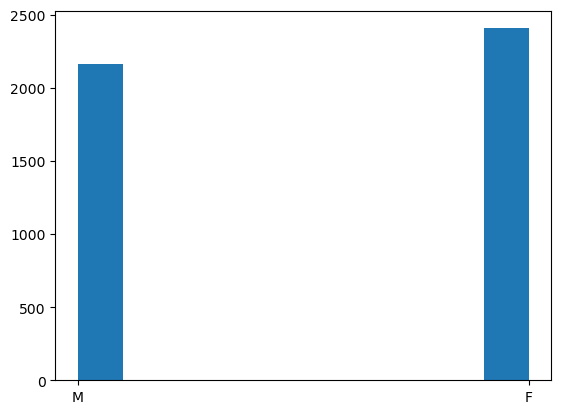

In [93]:
plt.hist(final_preop_cases['sex'])

(array([4315.,    0.,    0.,    0.,    0.,  208.,    0.,    0.,    0.,
          42.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

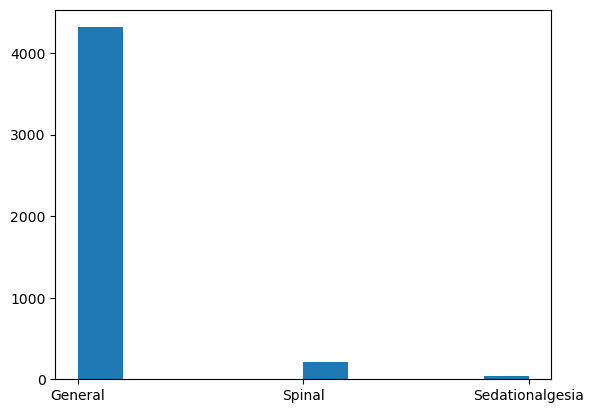

In [94]:
plt.hist(final_preop_cases['ane_type'])


<AxesSubplot:ylabel='Density'>

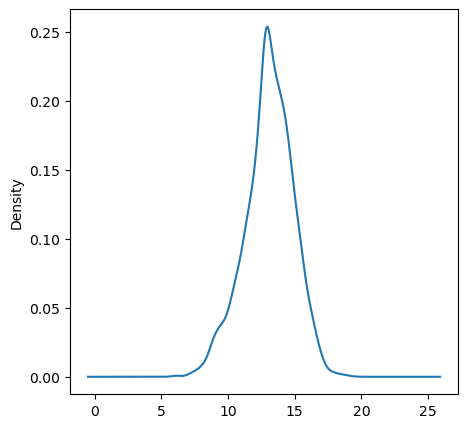

In [95]:
plt.figure(figsize=(5,5))
final_preop_cases['preop_hb'].plot(kind='density')
#hb:Hemoglobin (g/dl) [13-17 reference value]

<AxesSubplot:ylabel='Density'>

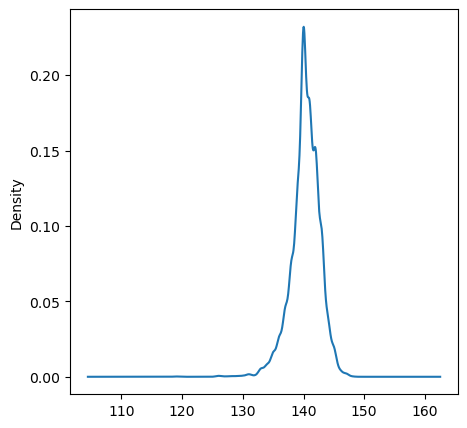

In [96]:
plt.figure(figsize=(5,5))
final_preop_cases['preop_na'].plot(kind='density')
#na:sodium (mmol/l) [135-145 reference value]

In [97]:
#categorical and numerical columns
cat_cols=final_preop_cases.select_dtypes(include=['object']).columns
num_cols = final_preop_cases.select_dtypes(include=np.number).columns.tolist()
print("Categorical Variables:")
print(cat_cols)
print("Numerical Variables:")
print(num_cols)



Categorical Variables:
Index(['sex', 'department', 'optype', 'ane_type', 'preop_ecg', 'preop_pft'], dtype='object')
Numerical Variables:
['outcome', 'age', 'bmi', 'asa', 'preop_htn', 'preop_dm', 'preop_hb', 'preop_plt', 'preop_pt', 'preop_aptt', 'preop_na', 'preop_k', 'preop_gluc', 'preop_alb', 'preop_ast', 'preop_alt', 'preop_bun', 'preop_cr']


(array([117., 157., 299., 494., 613., 972., 825., 633., 366.,  89.]),
 array([18. , 25.1, 32.2, 39.3, 46.4, 53.5, 60.6, 67.7, 74.8, 81.9, 89. ]),
 <BarContainer object of 10 artists>)

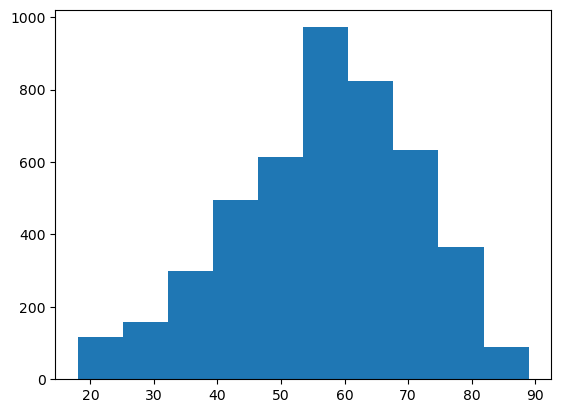

In [98]:
import matplotlib.pyplot as plt
plt.hist(final_preop_cases['age'])


## label encoding

In [99]:
cols = ['sex', 'department', 'optype', 'ane_type', 'preop_ecg', 'preop_pft']
#
# Encode labels of multiple columns at once
#
final_preop_cases[cols] = final_preop_cases[cols].apply(LabelEncoder().fit_transform)
#
# Print head
#
final_preop_cases.head()



,outcome,age,bmi,asa,sex,department,optype,ane_type,preop_htn,preop_dm,preop_ecg,preop_pft,preop_hb,preop_plt,preop_pt,preop_aptt,preop_na,preop_k,preop_gluc,preop_alb,preop_ast,preop_alt,preop_bun,preop_cr
0,0,77,26.3,2.0,1,0,2,0,1,0,10,6,14.1,189.0,94.0,33.2,141.0,3.1,134.0,4.3,18.0,16.0,10.0,0.82
1,0,54,19.6,2.0,1,0,7,0,0,0,10,6,10.2,251.0,110.0,31.9,143.0,4.7,88.0,3.8,18.0,15.0,14.0,0.86
2,0,62,24.4,1.0,1,0,0,0,0,0,10,6,14.2,373.0,103.0,30.3,144.0,4.9,87.0,4.2,17.0,34.0,14.0,1.18
7,0,81,27.4,2.0,0,0,1,0,0,0,10,6,12.1,186.0,92.0,31.3,142.0,4.5,101.0,3.7,16.0,10.0,11.0,0.69
8,0,32,20.4,1.0,0,0,0,0,0,0,10,6,13.7,141.0,96.0,32.1,140.0,4.2,91.0,4.5,14.0,11.0,8.0,0.58


In [33]:
print(final_preop_cases.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4565 entries, 0 to 6387
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   case_id     4565 non-null   int64  
 1   outcome     4565 non-null   int64  
 2   age         4565 non-null   int32  
 3   bmi         4565 non-null   float64
 4   asa         4565 non-null   float64
 5   sex         4565 non-null   int32  
 6   department  4565 non-null   int32  
 7   optype      4565 non-null   int32  
 8   ane_type    4565 non-null   int32  
 9   preop_htn   4565 non-null   int64  
 10  preop_dm    4565 non-null   int64  
 11  preop_ecg   4565 non-null   int32  
 12  preop_pft   4565 non-null   int32  
 13  preop_hb    4565 non-null   float64
 14  preop_plt   4565 non-null   float64
 15  preop_pt    4565 non-null   float64
 16  preop_aptt  4565 non-null   float64
 17  preop_na    4565 non-null   float64
 18  preop_k     4565 non-null   float64
 19  preop_gluc  4565 non-null  

In [100]:
final_preop_cases['asa'] = final_preop_cases['asa'].astype(int)  # cast data type to int


In [101]:
final_preop_cases[['preop_hb', 'preop_plt', 'preop_pt', 
                   'preop_aptt', 'preop_na', 'preop_k', 
                   'preop_gluc', 'preop_alb', 'preop_ast', 'preop_alt', 
                   'preop_bun', 'preop_cr','bmi']] = final_preop_cases[['preop_hb', 'preop_plt', 'preop_pt', 
                   'preop_aptt', 'preop_na', 'preop_k', 
                   'preop_gluc', 'preop_alb', 'preop_ast', 'preop_alt', 
                   'preop_bun', 'preop_cr','bmi']].round(3)

In [102]:
print(final_preop_cases[['preop_hb','preop_cr']])

      preop_hb  preop_cr
0         14.1      0.82
1         10.2      0.86
2         14.2      1.18
7         12.1      0.69
8         13.7      0.58
...        ...       ...
6383      14.5      0.99
6384      15.2      0.84
6385      12.6      0.66
6386      12.5      0.65
6387       8.6      0.64

[4565 rows x 2 columns]


0    4547
1      18
Name: outcome, dtype: int64

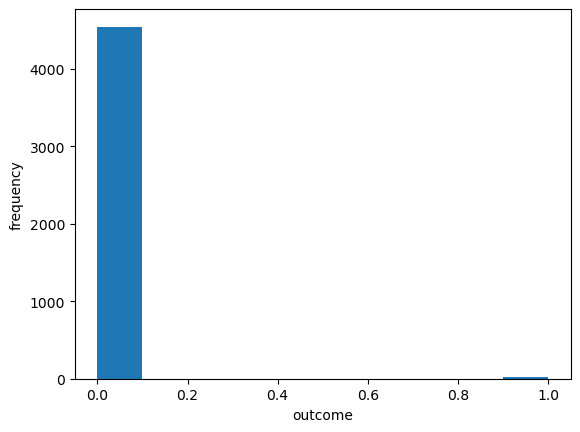

In [103]:
#unbalanced data plot histogram
plt.hist(final_preop_cases['outcome' ])
plt.xlabel('outcome')
plt.ylabel('frequency')                                                               
final_preop_cases['outcome'].value_counts()

## features and label

In [104]:
X = final_preop_cases.drop(columns=['outcome','age','sex'],axis=1)
y = final_preop_cases['outcome']

In [105]:
print(len(X))

4565


# Principal Component Analysis (PCA)

Principal Component Analysis (PCA) is a dimensionality reduction technique helps in reducing the number of features (dimensions) within a dataset while retaining the most important information. To explore and understand the underlying structure of the data.

In [106]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming 'X' contains your 23-dimensional feature data
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to reduce the dimensionality to 15
pca = PCA(n_components=15,random_state=42)
X_pca = pca.fit_transform(X_scaled)

# X_pca now contains the top 15 principal components, which can be considered as the selected top 15 features


# Balance the data

SMOTE (Synthetic Minority Over-sampling Technique) is a technique used to address class imbalance in a dataset. As, in our dataset ,the number of survivors exceeds the number of fatalities."

In [107]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Apply SMOTE to the entire dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_pca, y)

# Split the resampled data into training (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Now, you have balanced training data in X_train, y_train,
# and validation/test sets in X_validation, X_test, y_validation, y_test

In [108]:
print("Training Set   :: X_train :",X_train.shape, " y_train :",y_train.shape)
print("Validation Set :: X_ validation: ",X_validation.shape," y_validation: " ,y_validation.shape)
print("Testing Set    :: X_test :",X_test.shape," y_test:" ,y_test.shape)


Training Set   :: X_train : (6365, 15)  y_train : (6365,)
Validation Set :: X_ validation:  (1364, 15)  y_validation:  (1364,)
Testing Set    :: X_test : (1365, 15)  y_test: (1365,)


No. of deaths in balanced data(training set)  3197
No. of alive in balanced data(training set)  3168


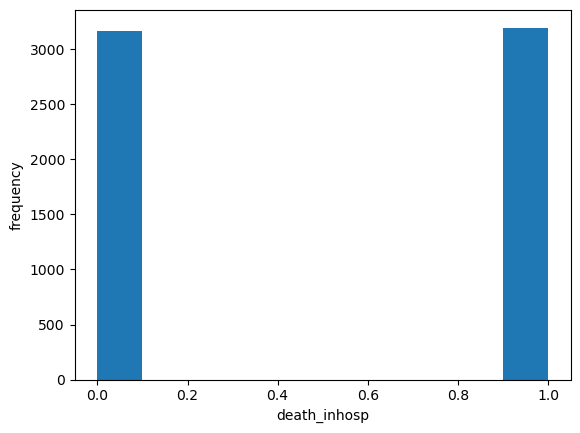

In [110]:
#balanced data plot histogram
plt.hist(y_train)
plt.xlabel('death_inhosp')
plt.ylabel('frequency')
print("No. of deaths in balanced data(training set) ",sum(y_train==1))
print("No. of alive in balanced data(training set) ",sum(y_train==0))


In [111]:
print("No. of deaths in testing set ",sum(y_test==1))
print("No. of alive in testing set ",sum(y_test==0))



No. of deaths in testing set  676
No. of alive in testing set  689


In [112]:
print("No. of deaths in validation set ",sum(y_validation==1))
print("No. of alive in validation set ",sum(y_validation==0))



No. of deaths in validation set  674
No. of alive in validation set  690


# lazypredict
We have used lazyClassifier for quick model selection(comprehensive overview of various machine learning models' performances) and top 4 models which performed best here would be used for further Hyperparameter tuning

In [113]:
pip install lazypredict

Note: you may need to restart the kernel to use updated packages.


In [114]:
import lazypredict

In [115]:
from lazypredict.Supervised import LazyClassifier

In [116]:

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:12<00:00,  2.29it/s]

[LightGBM] [Info] Number of positive: 3197, number of negative: 3168
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6365, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502278 -> initscore=0.009112
[LightGBM] [Info] Start training from score 0.009112
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
ExtraTreesClassifier               1.00               1.00     1.00      1.00   
LGBMClassifier                     0.99               0.99     0.99      0.99   
RandomForestClassifier             0.99               0.99     0.99      0.99   
XGBClassifier                      0.99   

# Hyperparameter tuning

## 1. ExtraTreeClassifier

In [143]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import ExtraTreeClassifier
from sklearn.metrics import accuracy_score

# Create the ExtraTreeClassifier
extra_tree_model = ExtraTreeClassifier(random_state=42)

# Define hyperparameters for tuning
param_grid = {
    'max_depth': [32],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create GridSearchCV instance
grid_search = GridSearchCV(extra_tree_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(best_params)
# Train the ExtraTreeClassifier with the best hyperparameters on the combined train and validation sets
best_extra_tree_model = ExtraTreeClassifier(**best_params, random_state=42)
best_extra_tree_model.fit(np.concatenate((X_train, X_validation)), np.concatenate((y_train, y_validation)))

# Make predictions on the test set
predictions_test = best_extra_tree_model.predict(X_test)

# Make predictions on the validation set
predictions_validation =best_extra_tree_model.predict(X_validation)



y_pred_prob_ml1 = best_extra_tree_model.predict_proba(X_test)[:, 1]  #  [:, 1] for the positive class label

# y_pred_prob_ml1 now contains the predicted probabilities for the positive class


# Evaluate the model on the test set
accuracy_test_etc = accuracy_score(y_test, predictions_test)
print(f"Test Accuracy: {accuracy_test_etc}")



# Measure accuracy on the validation set
val_accuracy = accuracy_score(y_validation, predictions_validation)
print("Validation Accuracy :", val_accuracy)

{'max_depth': 32, 'min_samples_leaf': 1, 'min_samples_split': 2}
Test Accuracy: 0.9772893772893773
Validation Accuracy : 0.999266862170088


### confusion matrix of ExtraTreeClassifier

In [163]:
from sklearn.metrics import confusion_matrix, classification_report


# Confusion Matrix
conf_matrix_etc = confusion_matrix(y_test, predictions_test)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_test, predictions_test)
print("Classification Report:")
print(class_report)


Confusion Matrix:
[[651  38]
 [  4 672]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       689
           1       0.96      0.99      0.98       676

    accuracy                           0.98      1365
   macro avg       0.98      0.98      0.98      1365
weighted avg       0.98      0.98      0.98      1365



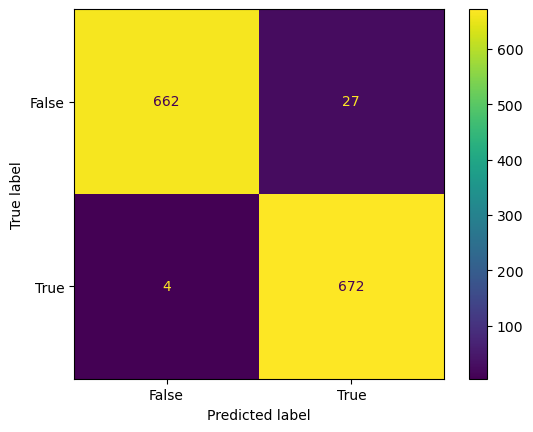

In [164]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix_etc, display_labels = [False, True])

cm_display.plot()
plt.show()

## 2. LGBMClassifier

In [171]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

# Assuming you already have your feature and target variables: X_train, y_train, X_test, y_test, X_validation, y_validation

# Convert the datasets to LightGBM dataset format
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)
val_data = lgb.Dataset(X_validation, label=y_validation)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'num_leaves': [31, 64],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200]
}

# Initialize the LGBMClassifier
lgbm = lgb.LGBMClassifier()

# Initialize GridSearchCV with the classifier and parameter grid
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, n_jobs=-1, scoring='accuracy')

# Perform the grid search on the training dataset
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_
print(best_params)
# Use the best hyperparameters to train the LGBMClassifier
best_lgbm = lgb.LGBMClassifier(**best_params)
best_lgbm.fit(X_train, y_train)


y_pred_prob_ml2 = best_lgbm.predict_proba(X_test)[:, 1] 
# Make predictions on the validation set
y_pred_val_lgb = best_lgbm.predict(X_validation)



# Evaluate the model's accuracy on the validation set
accuracy_val_lgb = accuracy_score(y_validation, y_pred_val_lgb)
print("Validation Set Accuracy:", accuracy_val_lgb)

# predict the results
y_pred_lgb=best_lgbm.predict(X_test)
print(y_pred_lgb)

# view accuracy
from sklearn.metrics import accuracy_score
test_accuracy_lgb=accuracy_score(y_pred_lgb, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(test_accuracy_lgb))


[LightGBM] [Info] Number of positive: 3197, number of negative: 3168
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 6365, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502278 -> initscore=0.009112
[LightGBM] [Info] Start training from score 0.009112
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

#best parameters of LGBM:{'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 64}

### confusion matrix of LGBMClassifier

In [161]:
from sklearn.metrics import confusion_matrix, classification_report
# Confusion Matrix
conf_matrix_lgb = confusion_matrix(y_test, y_pred_lgb)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_pred_lgb)
print("Classification Report:")
print(class_report)


Confusion Matrix:
[[651  38]
 [  4 672]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       689
           1       0.99      1.00      1.00       676

    accuracy                           1.00      1365
   macro avg       1.00      1.00      1.00      1365
weighted avg       1.00      1.00      1.00      1365



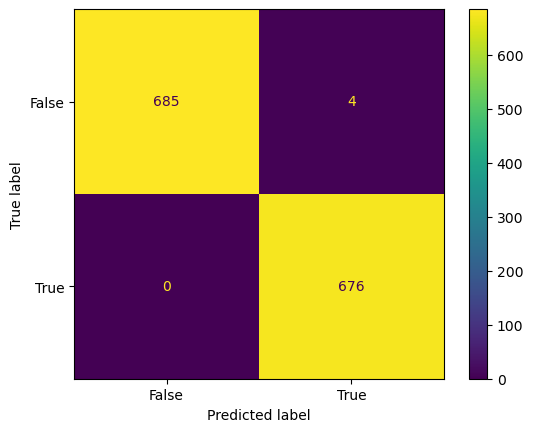

In [162]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix_lgb, display_labels = [False, True])

cm_display.plot()
plt.show()

## 3. RandomForestClassifier

In [172]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from scipy.stats import randint

param_dist = {
    "n_estimators": randint(10, 100),
    "max_depth": randint(1, 20),
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 20),
    "bootstrap": [ False,True]
}

# Instantiate the RandomForestClassifier

# Instantiate the RandomForestClassifier with the hyperparameter bootstrap set to False
rfc = RandomForestClassifier(random_state=42)


# Perform Randomized Search to find the best hyperparameters
random_search = RandomizedSearchCV(rfc, param_distributions=param_dist, n_iter=10, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# Get the best estimator
best_rf = random_search.best_estimator_
print("best rf:",best_rf)
# Make predictions on the validation set using the best estimator
y_pred_val_rf = best_rf.predict(X_validation)


y_pred_prob_ml3  = best_rf.predict_proba(X_test)[:, 1] 

# Measure accuracy on the validation set
val_accuracy_rf = accuracy_score(y_validation, y_pred_val_rf)
print("RandomForestClassifier Validation Accuracy with Hyperparameter Tuning:", val_accuracy_rf)

# Make predictions on the test set using the best estimator
y_pred_test_rf= best_rf.predict(X_test)

# Measure accuracy on the test set
test_accuracy_rf = accuracy_score(y_test, y_pred_test_rf)
print("RandomForestClassifier Test Accuracy with Hyperparameter Tuning:", test_accuracy_rf)

best rf: RandomForestClassifier(bootstrap=False, max_depth=15, min_samples_leaf=11,
                       min_samples_split=9, n_estimators=70, random_state=42)
RandomForestClassifier Validation Accuracy with Hyperparameter Tuning: 0.9611436950146628
RandomForestClassifier Test Accuracy with Hyperparameter Tuning: 0.9692307692307692


### confusion matrix of RandomForestClassifier

In [158]:
from sklearn.metrics import confusion_matrix, classification_report
# Confusion Matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_test_rf)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_pred_test_rf)
print("Classification Report:")
print(class_report)


Confusion Matrix:
[[651  38]
 [  4 672]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.97       689
           1       0.95      0.99      0.97       676

    accuracy                           0.97      1365
   macro avg       0.97      0.97      0.97      1365
weighted avg       0.97      0.97      0.97      1365



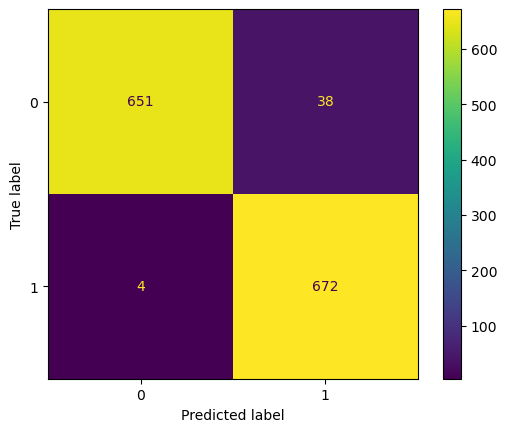

In [170]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix_rf, display_labels = [0, 1])

cm_display.plot()
plt.show()
#0:patient survived 1: patient dead
#TN:651,FP:38,FN:4,TP:672

## ROC-AUC curve

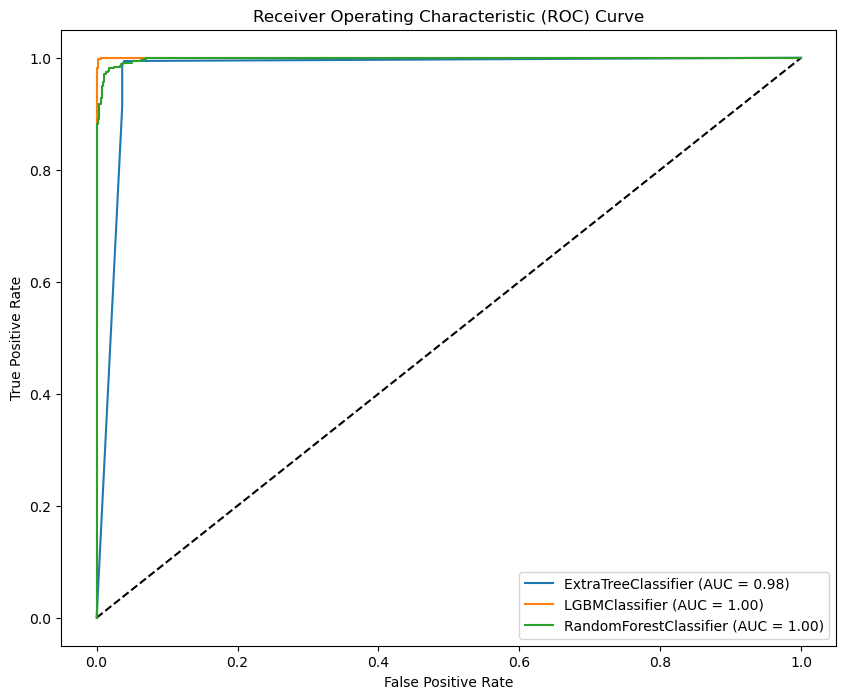

In [151]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have the predicted probabilities for each algorithm named as y_pred_prob_ml1, y_pred_prob_ml2, etc.
# And the true labels named as y_true

# Plotting the ROC curves for each algorithm
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--')

# Calculating and plotting ROC curve for EXtraTreeClassifier
fpr_ml1, tpr_ml1, _ = roc_curve(y_test, y_pred_prob_ml1)
roc_auc_ml1 = auc(fpr_ml1, tpr_ml1)
plt.plot(fpr_ml1, tpr_ml1, label='ExtraTreeClassifier (AUC = %0.2f)' % roc_auc_ml1)

# Calculating and plotting ROC curve for LGBMClassifier
fpr_ml2, tpr_ml2, _ = roc_curve(y_test, y_pred_prob_ml2)
roc_auc_ml2 = auc(fpr_ml2, tpr_ml2)
plt.plot(fpr_ml2, tpr_ml2, label='LGBMClassifier (AUC = %0.2f)' % roc_auc_ml2)

# Calculating and plotting ROC curve for RandomForestClassifier
fpr_ml3, tpr_ml3, _ = roc_curve(y_test, y_pred_prob_ml3)
roc_auc_ml3 = auc(fpr_ml3, tpr_ml3)
plt.plot(fpr_ml3, tpr_ml3, label='RandomForestClassifier (AUC = %0.2f)' % roc_auc_ml3)



# Adding titles and labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Show the plot
plt.show()




This indicates that the EXtraTreeClassifier model has very high discrimination ability, with a strong ability to distinguish between the positive and negative classes. 

## Comparison of Accuracies

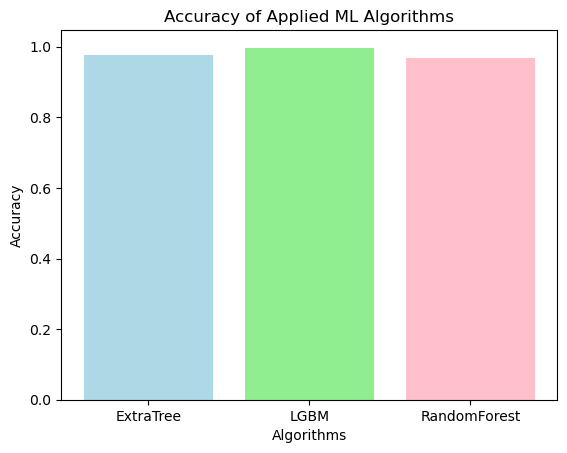

In [155]:
import matplotlib.pyplot as plt

# Assuming you have the accuracy values of the four ML algorithms stored in a list or array
accuracies = [accuracy_test_etc, test_accuracy_lgb, test_accuracy_rf]  # Replace with actual accuracy values

# Names of the machine learning algorithms
labels = ['ExtraTree', 'LGBM', 'RandomForest']

# Plotting the accuracy scores
plt.bar(labels, accuracies, color=['lightblue', 'lightgreen',  'pink'])

# Adding titles and labels
plt.title('Accuracy of Applied ML Algorithms')
plt.xlabel('Algorithms')
plt.ylabel('Accuracy')

# Displaying the plot
plt.show()


## conclusion

Based on our analysis, the ExtraTreeClassifier has emerged as the most effective model among the three. With a test accuracy of 0.977 and a robust ROC-AUC score of 0.98, it consistently demonstrates superior performance in distinguishing between the classes it is trained to predict. The crucial insight from the confusion matrix of this model is its ability to accurately identify cases where a patient would unfortunately pass away, a pivotal factor in a medical context.

In summary, the ExtraTreeClassifier, configured with a 'max_depth' of 32, 'min_samples_leaf' of 1, and 'min_samples_split' of 2, exhibits exceptional accuracy in predicting patient outcomes, particularly in accurately identifying cases where a patient would not survive.

## Future scope

Exploring the inclusion of emergency cases and underage patients can be a valuable expansion for this analysis. Incorporating these additional demographics could provide a more comprehensive understanding of predictive capabilities across a wider range of scenarios. Moreover, extending the analysis to cover both intraoperative and postoperative periods can offer insights into the performance of the model at different stages of patient care, potentially enhancing its overall utility and effectiveness.